Area Terms
New Open Area
[2.18167771e-05 2.47542225e-05 2.67184829e-05 2.40203460e-05
 2.10956377e-05 2.12511256e-05 1.83413993e-05 1.55376096e-05
 1.92881763e-05]
Current Open Area
3.926990816987241e-06
0.014477752855903598
0.0009652506654733253


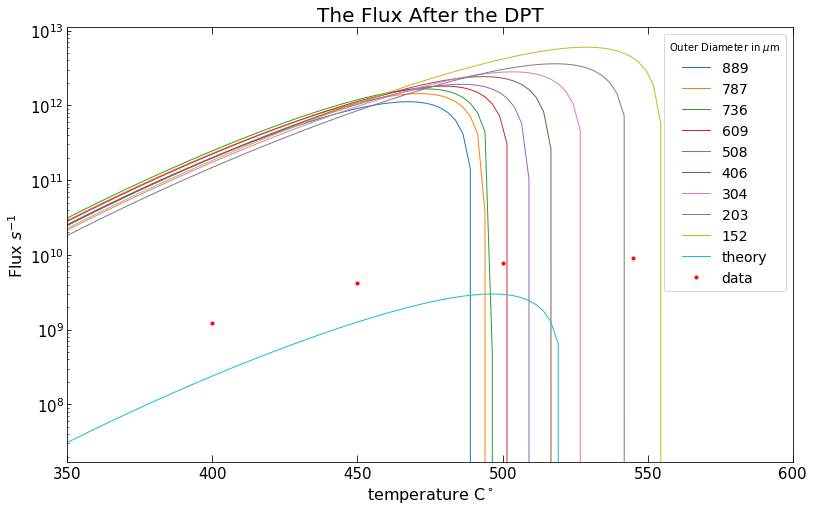

In [38]:
#********************************************************************
# Note: everything is converted to SI units unless printed otherwise
# takes into account the clamp
# looks at the flux vs temperature for each tube size
# plot is made yet it not annoying to change parameters
#********************************************************************

#Global Constants
kB       = 1.38064852*10**(-23) # m^2 kg s^-2 K^-1 (boltzmann constant)
M        = 171*1.66054e-27      # mass of Yb in kg
sigma    = 1.5*10**(-19)        # cross sectional area of an atom

#Libraries
import matplotlib.pyplot as plt #plotting
import numpy as np
import matplotlib.pylab as pylab #plotting
import scipy.integrate as integrate #integrating
from numpy import sqrt, sin, cos, pi
from decimal import Decimal

#formatting plots
pylab.rcParams['figure.figsize'] = (13,8)
pylab.rcParams['figure.autolayout'] = False
pylab.rcParams.update({'axes.labelsize': 20})
pylab.rcParams.update({'xtick.labelsize': 15})
pylab.rcParams.update({'ytick.labelsize': 15})
pylab.rcParams.update({'lines.linewidth': 1.0})
pylab.rcParams.update({'axes.titlesize': 20.0})

pylab.rcParams.update({'ytick.direction': 'in'}) 
pylab.rcParams.update({'xtick.major.size': 7})   
pylab.rcParams.update({'xtick.direction': 'in'}) 
pylab.rcParams.update({'xtick.top': True}) 
pylab.rcParams.update({'xtick.minor.bottom': True}) 

plt.ylabel('Flux $s^{-1}$',fontsize=16)
plt.xlabel('temperature C$^\circ$', fontsize=16)

#Set Parameters
lowT = 350 
hghT = 600
steps = 100 
len_algn_fud = 3                              # alignment fudge factor
h_clamp      = 2*10**(-3)                     # height of the clamp

#Dimensional Parameters of DPT (m)
R_DPT         = 2.5*10**(-3)             # radius of DPT
L_to_DPT      = 518*10**(-3)             # length from the end of nozzle to the end of DPT   

# Our Current System
L_now = 12.7 * 10**(-3)
r_now = 0.5*10**(-3)
A_now = pi*r_now**2
N_now = 5

# outer diameter radius and inner array parameters picked from the sheet based on small wall thickness
rOD   = np.array([0.0425,0.0355,0.032,0.028,0.025,0.020,0.0163,0.012,0.008])*(0.0254/2) 
rID   = np.array([0.035 ,0.031 ,0.029,0.024,0.020,0.016,0.0120,0.008,0.006])*(0.0254/2) 
gauge = np.array(['19X','20XX','21XX','22XX','23XX','25XX','27X','30XX','33X'])    
dataT =np.array([400,450,500,545])
dataF =np.array([1.22*10**(9),4.2*10**(9),7.8*10**(9),9*10**(9)])

plot_label = rID*10**(6)*2

#*****************************************************************************************
# Calculating Dimensional Parameters
#*****************************************************************************************

# length and heigh calculation of the triangle
trngle_len    = 2*np.sqrt(3)*R_DPT       # length of the triangle to match DPT
h_trngle      = trngle_len*np.sqrt(3)/2  # height of the triangle to match DPT

# Number of tubes calculations
n             = trngle_len/(2*rOD)                          # number of tubes along the side of the triangle
N_tubes       = n*(n+1)/2                                   # number of tubes, triangular numbers formula

# Area calculations
A_trngle      = (trngle_len**(2)*sqrt(3)/4)                 # area of triangle nozzle without tubes
A_open        = A_trngle - N_tubes*pi*(rOD**2 - rID**2)     # m^2, total open area of nozzle 
area_DPT      = pi*R_DPT**(2)                               # area of the DPT  

# Angle and length of tubes calculations
theta_DPT     = np.arctan(R_DPT/L_to_DPT)                      # maximum angle of atoms out of the DPT 
L_opt         = rID/(np.tan(theta_DPT))                     # optimal length of tubes
L_opt_fud     = L_opt/len_algn_fud                          # fudged optimal length of tubes
L_to_DPT_fud  = L_to_DPT/len_algn_fud                          # optimal length of tubes with fudge factor
L_opt         = rID/(np.tan(theta_DPT))                     # optimal length of tubes
theta_DPT_fud = np.arctan(R_DPT/L_to_DPT_fud)                  # maximum angle with fudged length
theta_mx = np.arctan(r_now/L_now)

# Ratios - solid angle and the area ratio
r_sld_angles_fud = (theta_DPT)**2/(theta_DPT_fud)**2        # Area Ratio of theta_DPT and theta_DPT_fud
area_ratio       = area_DPT/A_trngle                        # Area Ratio
area_ratio_now   = area_DPT/(N_now*A_now)                   # previous area ratio/ current one
r_sld_angles_now = (theta_DPT)**2/(theta_mx)**2 

# NOT SURE ON USING AREA OF TRIANGLE FOR THIS AREA RATIO CALC -  SHOULD BE OPEN AREA!!!!???

# trapezoidal calculations for the clamp dimensions
clamp_lid_len = trngle_len + 2*h_clamp/(np.sqrt(3))
side_clamp    = np.sqrt(h_clamp**(2)+ h_clamp**(2)/3)

#*****************************************************************************************
# Calculating Temperature Parameters
#*****************************************************************************************

# Convert set temperature in Celcius to Kelvin
T_oven       = np.linspace(lowT, hghT, steps)  # range of the temperature of the oven in celcius  
T = T_oven + 273

# Quantities which all Depend on temperature: pressure, density, velocity
P        = 10**(5.006 + 9.111 - 8111/T -1.0849*np.log10(T)) # pressure calculation
v_tilde  = np.sqrt(kB*T/M)                                  # convenient redefinition
n_0      = P/(kB*T)                                         # Number of atoms per Volume
v_mp     = np.sqrt(2)*v_tilde                               # most probable velocity
v_avg    = np.sqrt(8/(np.pi))*v_tilde                       # avergae velocity
v_rms    = np.sqrt(3)*v_tilde                               # root-mean-square velocity
MFP      = 1/(n_0*sigma)                                    # mean free path of the atoms

#*****************************************************************************************
# Flux Calculations
#*****************************************************************************************

# Integration
I       = integrate.quad(lambda x: sin(x)*cos(x)/2, 0, theta_DPT)     # integration for the ideal numbers
I_fud   = integrate.quad(lambda x: sin(x)*cos(x)/2, 0, theta_DPT_fud) # integration for the fudged numbers
I_now   = integrate.quad(lambda x: sin(x)*cos(x)/2, 0, theta_mx)
chk = np.array([])
for i in range(0,len(rOD)):
    for j in range(0,len(T_oven)):
        Flux = A_open[i]*v_mp[j]*n_0[j]*I[0]
        chk  = np.append(chk, Flux)

# For each radius there is now a range of temperature
# each sub array is the variation in flux due to temp, the giant array is for each radius
Flux_all = np.reshape(chk,(-1, len(T_oven)))

# NOTE: one square brace number in this 2D array represents which radius you want
# adding another is the element in 
# subarray

chk2 = np.array([])
for i in range(0,len(rOD)):
    for j in range(0,len(T_oven)):
        Flux_fud = A_open[i]*v_mp[j]*n_0[j]*I_fud[0]
        chk2  = np.append(chk2, Flux_fud)
        
Flux_fud_all = np.reshape(chk2,(-1, len(T_oven)))
Flux_DPT_fud  = Flux_fud_all*r_sld_angles_fud*area_ratio

# Fractions with collisions
chk_f = np.array([])
for i in range(0,len(rOD)):
    for j in range(0,len(T_oven)):
        f = L_opt_fud[i]/MFP[j] 
        chk_f = np.append(chk_f,f)
        
f_new  = np.reshape(chk_f,(-1,len(T_oven)))
f_now  = L_now/MFP

# storing all the fluxes in a 2D array

# ACCESSING:  the first brace number is the radius, the second is an element of flux for that radius
temp = np.array([])
for i in range(0,len(rOD)):
    Flux_calc = Flux_DPT_fud[i] - f_new[i]*Flux_DPT_fud[i]
    temp = np.append(temp,Flux_calc)

# total flux when collisions accounted for of new system
Flux_tot = np.reshape(temp,(-1,len(T_oven)))

# total flux of our current system after the DPT
Flux_now = N_now*A_now*n_0*I_now[0]*r_sld_angles_now*(1-f_now) 

# total flux of our system after the nozzle
Flux_noz = N_now*A_now*n_0*I_now[0]*(1-f_now) 

for i in range(0,len(rOD)):
    # plots after the DPT
     plt.plot(T_oven,Flux_tot[i], label=plot_label[i].astype(int)
    # plots after the nozzle
    # plt.plot(T_oven,Flux_fud_all[i], label=plot_label[i].astype(int)
)
    
plt.plot(T_oven,Flux_now, label='theory')
plt.plot(dataT,dataF,'r.',label='data')
#plt.plot(T_oven,theta_DPT_fud)

# minimum and maximum values on the plot
plt.ylim()
plt.xlim(xmin=lowT,xmax=hghT)
plt.yscale('log')
plt.title('The Flux After the DPT')
plt.legend(fontsize=14,title='Outer Diameter in $\mu$m')
pylab.savefig('FluxvsTemp.pdf', format='pdf', dpi=1000,bbox_inches='tight')


# What is the biggest contributor to the new flux calculations?
print('Area Terms')
print('New Open Area')
print(A_open)
print('Current Open Area')
print(A_now*N_now)

print(theta_DPT_fud)
print(theta_mx)



In [3]:


print('inner diameter in inches')
print(rID*2/0.0254)
print('      ')

print('outer diameter in inches')
print(rOD*2/0.0254)
print('      ')

print('Optimal tube lengths in mm (ideal case of perfect alignment)')
print(L_opt*10**3)
print('      ')

print('Gauge')
print(gauge)
print('      ')

print('Number of tubes necessary for corresponding lengths')
print(N_tubes)
print('      ')

print('number of tubes along one side length of the triangle')
print(n)
print('      ')

print('Length of the triangle in mm')
print(trngle_len*10**(3))
print('      ')

print('Height of the triangle in mm')
print(h_trngle*10**(3))
print('      ')

print('Length of the tubes (fudged) in mm')
print(L_opt_fud*10**(3))
print('      ')


print('Top of clamp length (mm):')
print(clamp_lid_len*10**(3))
print('      ')

print('Side of Clamp size: (mm)')
print(side_clamp*10**(3))
print('      ')

print('New dimensions of triangle (mm)')
print((side_clamp + trngle_len)*10**(3))




inner diameter in inches


NameError: name 'rID' is not defined

Area Terms
Open area times the area ratio
[1.31904188e-05 1.49663977e-05 1.61539891e-05 1.45226961e-05
 1.27544181e-05 1.28484261e-05 1.10892061e-05 9.39403548e-06
 1.16616273e-05]
Current Open Area times ratio
1.9634954084936207e-05
Open area
[2.18167771e-05 2.47542225e-05 2.67184829e-05 2.40203460e-05
 2.10956377e-05 2.12511256e-05 1.83413993e-05 1.55376096e-05
 1.92881763e-05]
Current Open Area
3.926990816987241e-06
new solid angles term
1.0
old solid angles term
24.99962732291953
integral new
5.8230482772628145e-06
integral current
2.3292713945906865e-07
theta_max
0.0009652506654733253
theta_dpt
0.00482621735455257
area ratio 
0.6045997880780726
open area ratio
[5.55559668 6.30361099 6.8038058  6.11673089 5.37196002 5.41155471
 4.67059897 3.9566198  4.91169377]
ratio of these solid angle terms
0.04000059629221773
ratio of integral terms
24.99944098736539
     
Divergence Angles
New
0.00482621735455257
current
0.0009652506654733253
inner diameter in inches
[0.035 0.031 0.029 0.024 0

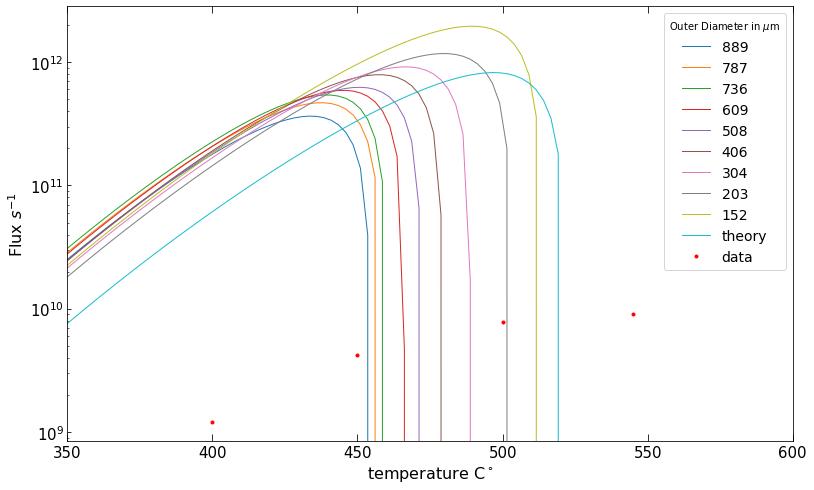

In [37]:
#********************************************************************
# Note: everything is converted to SI units unless printed otherwise
# takes into account the clamp
# looks at the flux vs temperature for each tube size
# plot is made yet it not annoying to change parameters
#********************************************************************

#Global Constants
kB       = 1.38064852*10**(-23) # m^2 kg s^-2 K^-1 (boltzmann constant)
M        = 171*1.66054e-27      # mass of Yb in kg
sigma    = 1.5*10**(-19)        # cross sectional area of an atom

#Libraries
import matplotlib.pyplot as plt #plotting
import numpy as np
import matplotlib.pylab as pylab #plotting
import scipy.integrate as integrate #integrating
from numpy import sqrt, sin, cos, pi
from decimal import Decimal

#formatting plots
pylab.rcParams['figure.figsize'] = (13,8)
pylab.rcParams['figure.autolayout'] = False
pylab.rcParams.update({'axes.labelsize': 20})
pylab.rcParams.update({'xtick.labelsize': 15})
pylab.rcParams.update({'ytick.labelsize': 15})
pylab.rcParams.update({'lines.linewidth': 1.0})
pylab.rcParams.update({'axes.titlesize': 20.0})

pylab.rcParams.update({'ytick.direction': 'in'}) 
pylab.rcParams.update({'xtick.major.size': 7})   
pylab.rcParams.update({'xtick.direction': 'in'}) 
pylab.rcParams.update({'xtick.top': True}) 
pylab.rcParams.update({'xtick.minor.bottom': True}) 

plt.ylabel('Flux $s^{-1}$',fontsize=16)
plt.xlabel('temperature C$^\circ$', fontsize=16)

#Set Parameters
lowT = 350 
hghT = 600
steps = 100 
len_algn_fud = 1                              # alignment fudge factor
h_clamp      = 2*10**(-3)                     # height of the clamp

#Dimensional Parameters of DPT (m)
R_DPT         = 2.5*10**(-3)             # radius of DPT
L_to_DPT      = 518*10**(-3)             # length from the end of nozzle to the end of DPT   

# Our Current System
L_now = 12.7 * 10**(-3)
r_now = 0.5*10**(-3)
A_now = pi*r_now**2
N_now = 5


# outer diameter radius and inner array parameters picked from the sheet based on small wall thickness
rOD   = np.array([0.0425,0.0355,0.032,0.028,0.025,0.020,0.0163,0.012,0.008])*(0.0254/2) 
rID   = np.array([0.035 ,0.031 ,0.029,0.024,0.020,0.016,0.0120,0.008,0.006])*(0.0254/2) 
gauge = np.array(['19X','20XX','21XX','22XX','23XX','25XX','27X','30XX','33X'])    
dataT =np.array([400,450,500,545])
dataF =np.array([1.22*10**(9),4.2*10**(9),7.8*10**(9),9*10**(9)])

plot_label = rID*10**(6)*2
#*****************************************************************************************
# Calculating Dimensional Parameters
#*****************************************************************************************

# length and heigh calculation of the triangle
trngle_len    = 2*np.sqrt(3)*R_DPT       # length of the triangle to match DPT
h_trngle      = trngle_len*np.sqrt(3)/2  # height of the triangle to match DPT

# Number of tubes calculations
n             = trngle_len/(2*rOD)                          # number of tubes along the side of the triangle
N_tubes       = n*(n+1)/2                                   # number of tubes, triangular numbers formula

# Area calculations
A_trngle      = (trngle_len**(2)*sqrt(3)/4)                 # area of triangle nozzle without tubes
A_open        = A_trngle - N_tubes*pi*(rOD**2 - rID**2)     # m^2, total open area of nozzle 
area_DPT      = pi*R_DPT**(2)                               # area of the DPT  

# Angle and length of tubes calculations
theta_DPT     = np.arctan(R_DPT/L_to_DPT)                   # maximum angle of atoms out of the DPT 
L_opt         = rID/(np.tan(theta_DPT))                     # optimal length of tubes
L_opt_fud     = L_opt/len_algn_fud                          # fudged optimal length of tubes
L_to_DPT_fud  = L_to_DPT/len_algn_fud                       # optimal length of tubes with fudge factor
L_opt         = rID/(np.tan(theta_DPT))                     # optimal length of tubes
theta_DPT_fud = np.arctan(R_DPT/L_to_DPT_fud)               # maximum angle with fudged length
theta_mx      = np.arctan(r_now/L_now)

# Ratios - solid angle and the area ratio
r_sld_angles_fud = (theta_DPT)**2/(theta_DPT_fud)**2        # Area Ratio of theta_DPT and theta_DPT_fud
area_ratio       = area_DPT/A_trngle                        # Area Ratio
area_ratio_now   = area_DPT/(N_now*A_now)                   # previous area ratio/ current one
r_sld_angles_now = (theta_DPT)**2/(theta_mx)**2 

# NOT SURE ON USING AREA OF TRIANGLE FOR THIS AREA RATIO CALC -  SHOULD BE OPEN AREA!!!!???

# trapezoidal calculations for the clamp dimensions
clamp_lid_len = trngle_len + 2*h_clamp/(np.sqrt(3))
side_clamp    = np.sqrt(h_clamp**(2)+ h_clamp**(2)/3)

#*****************************************************************************************
# Calculating Temperature Parameters
#*****************************************************************************************

# Convert set temperature in Celcius to Kelvin
T_oven       = np.linspace(lowT, hghT, steps)  # range of the temperature of the oven in celcius  
T = T_oven + 273

# Quantities which all Depend on temperature: pressure, density, velocity
P        = 10**(5.006 + 9.111 - 8111/T -1.0849*np.log10(T)) # pressure calculation
v_tilde  = np.sqrt(kB*T/M)                                  # convenient redefinition
n_0      = P/(kB*T)                                         # Number of atoms per Volume
v_mp     = np.sqrt(2)*v_tilde                               # most probable velocity
v_avg    = np.sqrt(8/(np.pi))*v_tilde                       # avergae velocity
v_rms    = np.sqrt(3)*v_tilde                               # root-mean-square velocity
MFP      = 1/(n_0*sigma)                                    # mean free path of the atoms

#*****************************************************************************************
# Flux Calculations
#*****************************************************************************************

# Integration
I       = integrate.quad(lambda x: sin(x)*cos(x)/2, 0, theta_DPT)     # integration for the ideal numbers
I_fud   = integrate.quad(lambda x: sin(x)*cos(x)/2, 0, theta_DPT_fud) # integration for the fudged numbers
I_now   = integrate.quad(lambda x: sin(x)*cos(x)/2, 0, theta_mx)
chk = np.array([])
for i in range(0,len(rOD)):
    for j in range(0,len(T_oven)):
        Flux = A_open[i]*v_mp[j]*n_0[j]*I[0]
        chk  = np.append(chk, Flux)


# For each radius there is now a range of temperature
# each sub array is the variation in flux due to temp, the giant array is for each radius
Flux_all = np.reshape(chk,(-1, len(T_oven)))

# NOTE: one square brace number in this 2D array represents which radius you want
# adding another is the element in 
# subarray

chk2 = np.array([])
for i in range(0,len(rOD)):
    for j in range(0,len(T_oven)):
        Flux_fud = A_open[i]*v_mp[j]*n_0[j]*I_fud[0]
        chk2  = np.append(chk2, Flux_fud)
        
Flux_fud_all = np.reshape(chk2,(-1, len(T_oven)))
Flux_DPT_fud  = Flux_fud_all*r_sld_angles_fud*area_ratio

# Fractions with collisions
chk_f = np.array([])
for i in range(0,len(rOD)):
    for j in range(0,len(T_oven)):
        f = L_opt_fud[i]/MFP[j] 
        chk_f = np.append(chk_f,f)
        
f_new  = np.reshape(chk_f,(-1,len(T_oven)))
f_now  = L_now/MFP

# storing all the fluxes in a 2D array

# ACCESSING:  the first brace number is the radius, the second is an element of flux for that radius
temp = np.array([])
for i in range(0,len(rOD)):
    Flux_calc = Flux_DPT_fud[i] - f_new[i]*Flux_DPT_fud[i]
    temp = np.append(temp,Flux_calc)

# total flux when collisions accounted for of new system
Flux_tot = np.reshape(temp,(-1,len(T_oven)))

# total flux of our current system after DPT
Flux_now_DPT = N_now*A_now*n_0*v_mp*I_now[0]*r_sld_angles_now*(1-f_now) 

# total flux of our system after the nozzle
Flux_noz = N_now*A_now*n_0*I_now[0]*(1-f_now)*v_mp 

for i in range(0,len(rOD)):
    # plots after the DPT
     plt.plot(T_oven,Flux_tot[i], label=plot_label[i].astype(int)
    # plots after the nozzle
    # plt.plot(T_oven,Flux_fud_all[i], label=plot_label[i].astype(int)
)
    
#plt.plot(T_oven,Flux_noz, label='theory') # flux after nozzle
plt.plot(T_oven,Flux_now_DPT, label='theory') # flux after DPT
plt.plot(dataT,dataF,'r.',label='data') #experimental data
#plt.plot(T_oven,theta_DPT_fud)

# minimum and maximum values on the plot
plt.ylim()
plt.xlim(xmin=lowT,xmax=hghT)
plt.yscale('log')
#plt.title('The Flux After the Nozzle')
plt.legend(fontsize=14,title='Outer Diameter in $\mu$m')
pylab.savefig('FluxvsTemp_noz.pdf', format='pdf', dpi=1000,bbox_inches='tight')


# What is the biggest contributor to the new flux calculations?
print('Area Terms')
print('Open area times the area ratio')
print(A_open*area_ratio)
print('Current Open Area times ratio')
print(A_now*N_now*area_ratio_now )
print('Open area')
print(A_open)
print('Current Open Area')
print(A_now*N_now )

print('new solid angles term')
print(r_sld_angles_fud)
print('old solid angles term')
print(r_sld_angles_now)

print('integral new')
print(I_fud[0])
print('integral current')
print(I_now[0])
print('theta_max')
print(theta_mx)
print('theta_dpt')
print(theta_DPT)
print('area ratio ')
print(area_ratio)
print('open area ratio')
print(A_open/(A_now*N_now))

print('ratio of these solid angle terms')
print(r_sld_angles_fud/r_sld_angles_now)
print('ratio of integral terms')
print(I_fud[0]/I_now[0])

print('     ')

print('Divergence Angles')
print('New')
print(theta_DPT_fud)
print('current')
print(theta_mx)

print('inner diameter in inches')
print(rID*2/0.0254)
print('      ')

print('outer diameter in inches')
print(rOD*2/0.0254)
print('      ')

print('Optimal tube lengths in mm (ideal case of perfect alignment)')
print(L_opt*10**3)
print('      ')

print('Gauge')
print(gauge)
print('      ')

print('Number of tubes necessary for corresponding lengths')
print(N_tubes)
print('      ')

print('number of tubes along one side length of the triangle')
print(n)
print('      ')

print('Length of the triangle in mm')
print(trngle_len*10**(3))
print('      ')

print('Height of the triangle in mm')
print(h_trngle*10**(3))
print('      ')

print('Length of the tubes (fudged) in mm')
print(L_opt_fud*10**(3))
print('      ')


print('Top of clamp length (mm):')
print(clamp_lid_len*10**(3))
print('      ')

print('Side of Clamp size: (mm)')
print(side_clamp*10**(3))
print('      ')

print('New dimensions of triangle (mm)')
print((side_clamp + trngle_len)*10**(3))


